tgb - 6/13/2021 - The panel should include:  
-  The influence of progressive rescalings on the Tropical MSE  
-  The training curves indicating overall performance as a function of epoch    
-  Lat/lon maps of performance for both BF/CI networks    
-  PDFs of output prediction for pre/post processing

# Imports

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
import matplotlib.pylab as plb
# from mpl_toolkits.basemap import Basemap
# bm = Basemap()

import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Global Variables

In [2]:
# Load coordinates (just pick any file from the climate model run)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
path_folRG = '/DFS-L/DATA/pritchard/liranp/'
path_RG0K = path_folRG + 'SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.2013-'
path_RG0K = path_RG0K + '05-05-*.nc'

coor_RG = xr.open_mfdataset(path_RG0K,decode_cf=False)
latRG = coor_RG.lat; lonRG = coor_RG.lon; levRG = coor_RG.lev;
coor_RG.close();

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from

In [4]:
# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

New Data generator class for the climate-invariant network. Calculates the physical rescalings needed to make the NN climate-invariant

## Data Generators

### Choose between aquaplanet and realistic geography here

In [5]:
# GP paths below
#path_aquaplanet = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
#path_realgeography = ''

# GP /fast paths below
path_aquaplanet = '/fast/tbeucler/climate_invariant/aquaplanet/'

# Comet paths below
# path_aquaplanet = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
# path_realgeography = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

path = path_aquaplanet

### Data Generator using RH

In [6]:
#scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','QRL','QRS']

# New GP path below
TRAINFILE_RH = '2021_01_24_O3_small_shuffle.nc'
NORMFILE_RH = '2021_02_01_NORM_O3_RH_small.nc'
    
# Comet/Ankitesh path below
# TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
# NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
# VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [7]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using QSATdeficit

We only need the norm file for this generator as we are solely using it as an input to determine the right normalization for the combined generator

In [8]:
# New GP path below
TRAINFILE_QSATdeficit = '2021_02_01_O3_QSATdeficit_small_shuffle.nc'
NORMFILE_QSATdeficit = '2021_02_01_NORM_O3_QSATdeficit_small.nc'

In [9]:
in_vars_QSATdeficit = ['QSATdeficit','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_QSATdeficit = ['PHQ','TPHYSTND','QRL','QRS']

In [10]:
train_gen_QSATdeficit = DataGenerator(
    data_fn = path+TRAINFILE_QSATdeficit,
    input_vars = in_vars_QSATdeficit,
    output_vars = out_vars_QSATdeficit,
    norm_fn = path+NORMFILE_QSATdeficit,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using TNS

In [11]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_TNS = '2021_02_01_O3_TfromNS_small_shuffle.nc'
NORMFILE_TNS = '2021_02_01_NORM_O3_TfromNS_small.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [12]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BCONS

In [13]:
in_vars = ['QBP','BCONS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_BCONS = '2021_02_01_O3_BCONS_small_shuffle.nc'
NORMFILE_BCONS = '2021_02_01_NORM_O3_BCONS_small.nc'

In [14]:
train_gen_BCONS = DataGenerator(
    data_fn = path+TRAINFILE_BCONS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BCONS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BMSE

In [15]:
in_vars = ['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_BMSE = '2021_06_16_BMSE_small_shuffle.nc'
NORMFILE_BMSE = '2021_06_16_NORM_BMSE_small.nc'

In [16]:
train_gen_BMSE = DataGenerator(
    data_fn = path+TRAINFILE_BMSE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BMSE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using NSto220

In [17]:
in_vars = ['QBP','T_NSto220','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_T_NSto220 = '2021_03_31_O3_T_NSto220_small.nc'
NORMFILE_T_NSto220 = '2021_03_31_NORM_O3_T_NSto220_small.nc'

In [18]:
train_gen_T_NSto220 = DataGenerator(
    data_fn = path+TRAINFILE_T_NSto220,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_T_NSto220,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsDELQ

In [19]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsDELQ = '2021_02_01_O3_LHF_nsDELQ_small_shuffle.nc'
NORMFILE_LHF_nsDELQ = '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [20]:
train_gen_LHF_nsDELQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsDELQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsDELQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsQ

In [21]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsQ = '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
NORMFILE_LHF_nsQ = '2021_02_01_NORM_O3_LHF_nsQ_small.nc'

In [22]:
train_gen_LHF_nsQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator Combined (latest flexible version)

In [23]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
#if path==path_aquaplanet: out_vars=['PHQPERC','TPHYSTNDPERC','QRLPERC','QRSPERC']
out_vars = ['PHQ','TPHYSTND','QRL','QRS']

In [24]:
# TRAINFILE = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE = '2021_01_24_NORM_O3_small.nc'
# VALIDFILE = '2021_01_24_O3_VALID.nc'
# GENTESTFILE = 'CI_SP_P4K_valid.nc'

# In physical space
TRAINFILE = '2021_03_18_O3_TRAIN_M4K_shuffle.nc'
VALIDFILE = '2021_03_18_O3_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
TESTFILE_DIFFGEOG = '2021_04_18_RG_TRAIN_M4K_shuffle.nc'

# In percentile space
#TRAINFILE = '2021_04_09_PERC_TRAIN_M4K_shuffle.nc'
#TRAINFILE = '2021_01_24_O3_small_shuffle.nc'
#VALIDFILE = '2021_04_09_PERC_VALID_M4K.nc'
#TESTFILE = '2021_04_09_PERC_TEST_P4K.nc'

Old data generator by Ankitesh

Improved flexible data generator

In [41]:
train_gen_CI = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

In [23]:
valid_gen_CI = DataGeneratorCI(data_fn = path+VALIDFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

In [24]:
test_diffclimate_gen_CI = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

In [25]:
test_diffgeog_gen_CI = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

# First row: Progressive improvement in Tropical MSE in aquaplanet

## TO REDO: Load models and generators

In [25]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [32]:
# Model's path
# path_array = ['2021_02_01_MLR.hdf5','2021_02_01_MLR_RH.hdf5',
#               '2021_03_19_MLR_RH_BCONS.hdf5','2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5',
#              '2021_04_27_W2C_MLR.hdf5',
#               '2021_04_26_NN.hdf5','2021_04_26_NN_RH_BCONS_LHF_nsDELQ.hdf5',
#               '2021_04_27_W2C_NN.hdf5']
# path_array = [
#     '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
#     '2021_06_13_NN_RH_BCONS.hdf5',
#     '2021_04_26_NN_RH_BCONS_LHF_nsDELQ.hdf5',
#     '2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5',
#     '2021_04_27_W2C_NN.hdf5',
#     '2021_02_01_MLR.hdf5','2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5',
#     '2021_04_27_W2C_MLR.hdf5'
# ]
path_array = [
    '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
    '2021_06_21_NN_RH_BMSE.hdf5',
    '2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_NN.hdf5',
    '2021_02_01_MLR.hdf5',
    '2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_MLR.hdf5'
]

In [33]:
MODEL = {}

In [35]:
for ipath,path in enumerate(path_array):
    print('path=',path)
    MODEL[path] = load_model(path_HDF5+path,compile=False)

path= 2021_04_26_NN.hdf5
path= 2021_06_13_NN_RH.hdf5
path= 2021_06_21_NN_RH_BMSE.hdf5
path= 2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_NN.hdf5
path= 2021_02_01_MLR.hdf5
path= 2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_MLR.hdf5


In [36]:
TRAINFILE = '2021_03_18_O3_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_03_18_O3_VALID_P4K.nc'

In [37]:
Qscaling_array = [None,'RH','RH','RH','RH',None,None,'RH',None]
Tscaling_array = [None,None,'BCONS','BCONS','TfromNS',None,None,'BCONS',None]
LHFscaling_array = [None,None,None,'LHF_nsDELQ','LHF_nsDELQ',None,None,'LHF_nsDELQ',None]

In [38]:
inp_sub_Qarray = [None,train_gen_RH.input_transform.sub,train_gen_RH.input_transform.sub,
                  train_gen_RH.input_transform.sub,train_gen_RH.input_transform.sub,None,
                 None,train_gen_RH.input_transform.sub,None]
inp_div_Qarray = [None,train_gen_RH.input_transform.div,train_gen_RH.input_transform.div,
                  train_gen_RH.input_transform.div,train_gen_RH.input_transform.div,None,
                 None,train_gen_RH.input_transform.div,None]
inp_sub_Tarray = [None,None,train_gen_BCONS.input_transform.sub,train_gen_BCONS.input_transform.sub,
                  train_gen_TNS.input_transform.sub,None,
                 None,train_gen_BCONS.input_transform.sub,None]
inp_div_Tarray = [None,None,train_gen_BCONS.input_transform.div,train_gen_BCONS.input_transform.div,
                  train_gen_TNS.input_transform.div,None,
                 None,train_gen_BCONS.input_transform.div,None]
inp_sub_LHFarray = [None,None,None,train_gen_LHF_nsDELQ.input_transform.sub,
                    train_gen_LHF_nsDELQ.input_transform.sub,None,
                   None,train_gen_LHF_nsDELQ.input_transform.sub,None]
inp_div_LHFarray = [None,None,None,train_gen_LHF_nsDELQ.input_transform.div,
                    train_gen_LHF_nsDELQ.input_transform.div,None,
                   None,train_gen_LHF_nsDELQ.input_transform.div,None]

In [39]:
train_m4K = {}
train_p4K = {}

In [40]:
path_data = path_aquaplanet

In [41]:
for ipath,path in enumerate(path_array):
    train_m4K[path] = DataGeneratorCI(data_fn = path_data+TRAINFILE,
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_data+NORMFILE,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')
    train_p4K[path] = DataGeneratorCI(data_fn = path_data+TESTFILE_DIFFCLIMATE,
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_data+NORMFILE,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')

## Calculate MSE as a function of lev for out-of-sample TS

In [42]:
lat_ind = np.arange(26,40)
Nbatches = 30
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')

In [43]:
MSE = {}
MSE_gen = {}
INP = {}
VAR = {}

In [ ]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    MSE[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; MSE_gen[dataset] = {};
    if idataset==0: train_gen_array = train_m4K
    elif idataset==1: train_gen_array = train_p4K
    
    for ipath,path in enumerate(path_array):
        print('path=',path)
            
        model = MODEL[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(np.var(prd_geo,axis=2),axis=2)
            mse_gen = np.expand_dims(np.mean((tru_geo-prd_geo)[lat_ind,:,:]**2,axis=(0,1)),axis=1)

            if ibatch==0:
                MSE[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_gen[dataset][path] = mse_gen;
            else:
                MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_gen[dataset][path] = np.concatenate((MSE_gen[dataset][path],mse_gen),axis=1)

idataset= 0  & dataset= AQ-4K
path= 2021_04_26_NN.hdf5
path= 2021_06_13_NN_RH.hdf5
path= 2021_06_21_NN_RH_BMSE.hdf5
path= 2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5
path= 2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5
path= 2021_04_27_W2C_NN.hdf5


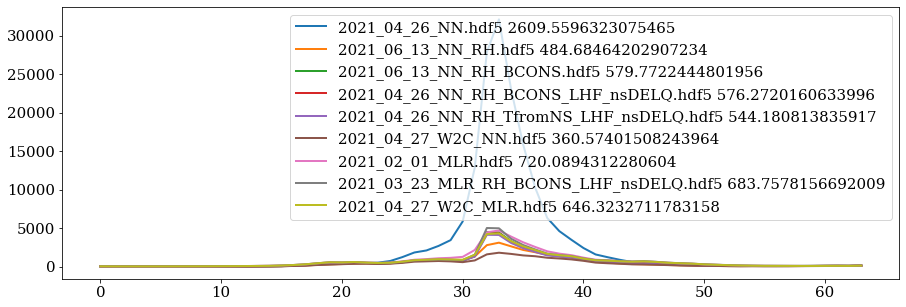

In [450]:
plt.figure(figsize=(15,5))
#for ikey,key in enumerate(['2021_02_01_MLR.hdf5', '2021_02_01_MLR_RH.hdf5', '2021_03_19_MLR_RH_BCONS.hdf5', '2021_03_23_MLR_RH_BCONS_LHF_nsDELQ.hdf5']):
for ikey,key in enumerate(MSE['AQ+4K'].keys()):
    plt.plot(np.mean(MSE['AQ+4K'][key],axis=(1,2)),label=key+' '+str(np.mean(MSE['AQ+4K'][key],axis=(0,1,2))))
plt.legend()
#plt.colorbar()

## Make row figure showing progressive profile improvement

In [333]:
fz = 15
lw = 2
siz = 100
TITa = '(a) MSE in (-4K) Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
TITb = '(b) Generalization Test: MSE in (+4K) Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
Y0 = 1.1

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

plot_log = [True,True,True]

In [365]:
LAB = ['BF (-4K)','$\\tilde{q}$','$\\tilde{q},\\tilde{T}$',
       '$\\tilde{q},\\tilde{T},\\tilde{\\mathrm{LHF}}}$',
       'BF (+4K)','','','']
XLAB = ['$\\dot{q}$','$\\dot{T}$','$\\dot{q}$','$\\dot{T}$',
        '$\\dot{q}$ (Zoom)','$\\dot{T}$ (Zoom)']
YLAB = 'Pressure [hPa]'

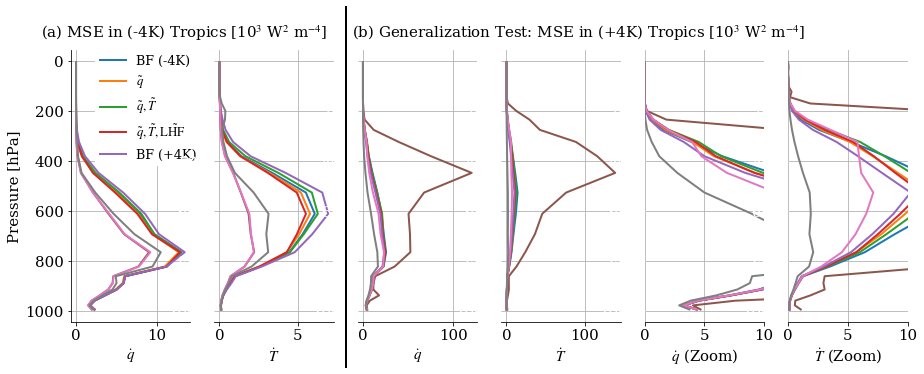

In [366]:
fig, ax = plt.subplots(1,6,figsize=(15,5))

for isub in range(6):
    
    for ipath,path in enumerate(path_array):

        if isub==0: toplot = np.mean(MSE_gen['AQ-4K'][path][:30,:],axis=1)/1e3
        elif isub==1: toplot = np.mean(MSE_gen['AQ-4K'][path][30:60,:],axis=1)/1e3
        elif isub==2 or isub==4: toplot = np.mean(MSE_gen['AQ+4K'][path][:30,:],axis=1)/1e3
        elif isub==3 or isub==5: toplot = np.mean(MSE_gen['AQ+4K'][path][30:60,:],axis=1)/1e3
        
        if isub==0: ax[isub].plot(toplot,coor.lev,label=LAB[ipath])
        else: ax[isub].plot(toplot,coor.lev)

    if isub==0: 
        leg = ax[0].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    
    ax[isub].invert_yaxis(); ax[isub].grid()
    ax[isub].set_xlabel(XLAB[isub])
    if isub==0: ax[0].set_ylabel(YLAB)

    for ipos,pos in enumerate(['right','top']):
        ax[isub].spines[pos].set_visible(False)
    if isub>0: 
        ax[isub].spines['left'].set_visible(False)
        ax[isub].tick_params(axis='y', colors='white')
    if isub==4 or isub==5: ax[isub].set_xlim((0,10))

plt.draw()
ax[0].text(-0.25,Y0,TITa,va='top',ha ='left',transform = ax[0].transAxes,fontsize=fz);
ax[2].text(2.35,Y0,TITb,va='top',ha ='left',transform = ax[0].transAxes,fontsize=fz);

xs = 0.5*(ax[1].get_position().x1+ax[2].get_position().x0)
line = plt.Line2D([xs,xs],[0,1], transform=fig.transFigure, color="black")
fig.add_artist(line)

# Second row: Training curves

## Load history files

In [394]:
path_PKL = '/export/nfs0home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
epoch = np.arange(1,21)

### Trained on ref climate

In [368]:
path_MLR_BF = path_PKL + 'PKL_DATA2021_04_26_MLR_hist.pkl'
hf = open(path_MLR_BF,'rb')
hist_MLR_BF = pickle.load(hf)
hist_MLR_BF = hist_MLR_BF['hist']

In [369]:
path_NN_BF1 = path_PKL + 'PKL_DATA2021_04_26_NN_hist.pkl'
path_NN_BF2 = path_PKL + 'PKL_DATA2021_05_04_NN_hist.pkl'

hf = open(path_NN_BF1,'rb')
hist_NN_BF1 = pickle.load(hf)
hist_NN_BF1 = hist_NN_BF1['hist']

hf = open(path_NN_BF2,'rb')
hist_NN_BF2 = pickle.load(hf)
hist_NN_BF2 = hist_NN_BF2['hist']

In [383]:
path_MLR_BCONS = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BCONS,'rb')
hist_MLR_BCONS = pickle.load(hf)
hist_MLR_BCONS = hist_MLR_BCONS['hist']

In [371]:
path_MLR_TfromNS = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS,'rb')
hist_MLR_TfromNS = pickle.load(hf)
hist_MLR_TfromNS = hist_MLR_TfromNS['hist']

In [372]:
path_NN_TfromNS = path_PKL + 'PKL_DATA2021_04_26_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS,'rb')
hist_NN_TfromNS = pickle.load(hf)
hist_NN_TfromNS = hist_NN_TfromNS['hist']

In [373]:
path_NN_BCONS1 = path_PKL + 'PKL_DATA2021_05_05_NN_RH_BCONS_LHF_nsDELQ_hist10.pkl'
hf = open(path_NN_BCONS1,'rb')
hist_NN_BCONS1 = pickle.load(hf)
hist_NN_BCONS1 = hist_NN_BCONS1['hist']

path_NN_BCONS2 = path_PKL + 'PKL_DATA2021_05_05_NN_RH_BCONS_LHF_nsDELQ_hist20.pkl'
hf = open(path_NN_BCONS2,'rb')
hist_NN_BCONS2 = pickle.load(hf)
hist_NN_BCONS2 = hist_NN_BCONS2['hist']

hist_NN_BCONS0 = {}
for key in hist_NN_BCONS1.keys():
    hist_NN_BCONS0[key] = np.append(hist_NN_BCONS1[key],hist_NN_BCONS2[key])

In [385]:
path_MLR_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_hist.pkl'
hf = open(path_MLR_BF_W2C,'rb')
hist_MLR_BF_W2C = pickle.load(hf)
hist_MLR_BF_W2C = hist_MLR_BF_W2C['hist']

### Warm to cold

In [ ]:
 PKL_DATA2021_04_27_W2C_NN_hist.pkl

In [ ]:
PKL_DATA2021_04_27_W2C_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl

In [ ]:
PKL_DATA2021_04_27_W2C_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl

In [ ]:
 PKL_DATA2021_04_27_W2C_NN_RH_BCONS_LHF_nsDELQ_hist.pkl

In [ ]:
PKL_DATA2021_04_27_W2C_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl

### RG to aquaplanet

## Make row figure showing transfer learning between cold/warm RG/aquaplanet

In [380]:
axT = {}

(0, 20)

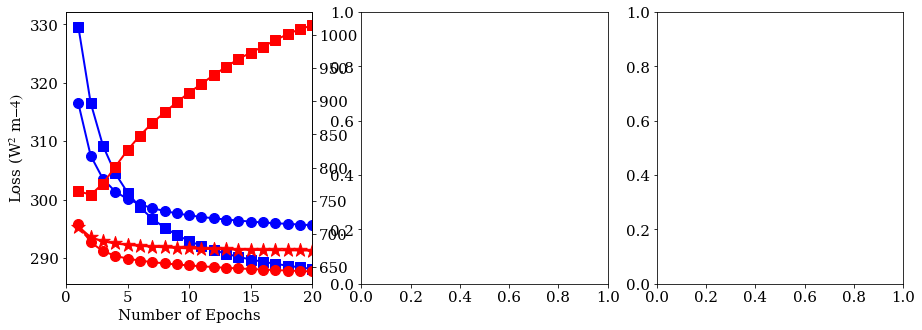

In [393]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(epoch,hist_MLR_BCONS['val_loss'],s=siz,color='b')
ax[0].plot(epoch,hist_MLR_BCONS['val_loss'],color='b')

ax[0].scatter(epoch,hist_MLR_BF['val_loss'],s=siz,color='b',marker='s')
ax[0].plot(epoch,hist_MLR_BF['val_loss'],color='b')



axT[0] = ax[0].twinx()

axT[0].scatter(epoch,hist_MLR_BF_W2C['val_loss'],s=siz,color='r')
axT[0].plot(epoch,hist_MLR_BF_W2C['val_loss'],color='r')

axT[0].scatter(epoch,hist_MLR_BF['trainP4K_loss'],s=siz,color='r',marker='s')
axT[0].plot(epoch,hist_MLR_BF['trainP4K_loss'],color='r',marker='s')

axT[0].scatter(epoch,hist_MLR_BCONS['trainP4K_loss'],color='r',marker='*',s=2*siz)
axT[0].plot(epoch,hist_MLR_BCONS['trainP4K_loss'],color='r',marker='*')

ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Loss (W$^{2}$ m${-4})$')
ax[0].set_xlim((0,20))

In [392]:
hist_MLR_BF_W2C['val_loss']

[714.2343943041906,
 687.2893925323822,
 674.0122135452511,
 666.8876705489562,
 662.6265663277511,
 659.682325463648,
 657.3923252887005,
 655.4962718303822,
 653.8405254040252,
 652.3953667378478,
 651.1046943283275,
 649.9376909636288,
 648.8569391151414,
 647.8999287823227,
 646.9941761314758,
 646.1612759033907,
 645.3850335779179,
 644.6755479970625,
 643.9998215473892,
 643.3667289453423]